In [ ]:
import os

In [15]:
from langgraph.graph import MessagesState, START, END, StateGraph
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition  # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
import operator
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


In [2]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [3]:
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b

In [4]:
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

In [5]:
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [6]:
search = DuckDuckGoSearchRun()

In [7]:
search.invoke("who is a current president of India?")

'Droupadi Murmu, who was born June 20, 1958, in Uparbeda, is the 15th president of India. She began her term in July 2022. Murmu is the first person from the tribal community, and the second woman after Pratibha Patil, to hold the office of president. She is also the first president to have been born in independent India as well as the youngest person to occupy the post. She previously served ... He was the 5th President of India. Varahagiri Venkata Giri: Odisha: August 24th, 1969: August 24th, 1974: He was the 4th President of India. Mohammad Hidayatullah: Chhattisgarh: July 20th, 1969 ... He was the 14th and current President of India. He became the President on 25 July 2017 and is a member of the Bhartiya Janata Party. He is the former Governor of Bihar. His approach towards ... Current President of India 2025. Smt. Droupadi Murmu was sworn in as the fifteenth President on July 25, 2022. She was the Governor of Jharkhand from 2015 to 2021 and has focused on empowering marginalized c

In [8]:
tools = [add, multiply, divide, search]

llm_with_tools = llm.bind_tools(tools)

In [9]:
#system message or prompt
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")

In [10]:
def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [13]:
# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)

builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")

builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

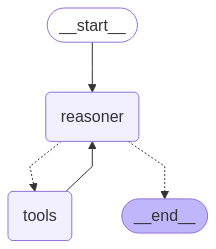

In [16]:
# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [17]:
messages = [HumanMessage(content="What is 2 times of current president of India's age?")]

In [18]:
messages = react_graph.invoke({"messages": messages})

In [19]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times of current president of India's age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_p10m)
 Call ID: call_p10m
  Args:
    query: current president of India age
================================= Tool Message =================================
Name: duckduckgo_search

Droupadi Murmu is an Indian politician who was elected as the 15th President of India on 21 July 2022 and took oath as the President of India on 25 July 2022, becoming the youngest President and the first to be born after India's independence. [9] The Economic Times; When she was young, her father and grandfather were the village headmen. The President of India should be a citizen of India and the minimum age to be a President is 35 years. He or she should qualify the conditions to be elected as a member of Lok. ... Current President of India. Droupadi Murmu

In [36]:
message1 = [HumanMessage(content="What is the result when the current age of UAE President add with  current prime minister of India's age then divide with 10?")]

In [37]:
messages1 = react_graph.invoke({ "messages": message1 })

In [38]:
for m in messages1['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the result when the current age of UAE President add with  current prime minister of India's age then divide with 10?
================================== Ai Message ==================================
Tool Calls:
  add (call_51ws)
 Call ID: call_51ws
  Args:
    a: 76
    b: 72
================================= Tool Message =================================
Name: add

148
================================== Ai Message ==================================
Tool Calls:
  divide (call_w7bg)
 Call ID: call_w7bg
  Args:
    a: 148
    b: 10
================================= Tool Message =================================
Name: divide

14.8
================================== Ai Message ==================================

The result when the current age of UAE President add with  current prime minister of India's age then divide with 10 is 14.8


In [39]:
## FInance AI

import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

In [41]:
get_stock_price("AAPL")

211.21

In [42]:
# Node
def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}

In [43]:
tools = [add, multiply, divide, search, get_stock_price]

In [44]:
llm_with_tools = llm.bind_tools(tools)

In [45]:
class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]

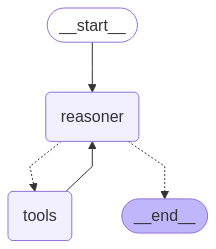

In [46]:
# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [47]:
response = react_graph.invoke({"query": "What is the stock price of Apple add 1000?", "messages": []})

In [48]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_t5zh)
 Call ID: call_t5zh
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

211.21
================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message ==================================

211.21 + 1000 = 1211.21


In [59]:
## test 2

response = react_graph.invoke({"query": "How many google stocks can i hold if i can invest 1050 dollars?", "messages": []})

In [60]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

How many google stocks can i hold if i can invest 1050 dollars?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_hn8y)
 Call ID: call_hn8y
  Args:
    ticker: GOOG
================================= Tool Message =================================
Name: get_stock_price

162.06
================================ Human Message =================================

How many google stocks can i hold if i can invest 1050 dollars?
================================== Ai Message ==================================

You can buy approximately 6.47 Google stocks.
